In [257]:
import cv2
import matplotlib.pyplot as plt
from mvextractor.videocap import VideoCap
import subprocess
import ffmpeg
import numpy as np
%matplotlib inline

In [62]:
def show(image):
    plt.imshow(cv2.cvtColor(image,cv2.COLOR_BGR2RGB))

## MV-Extractor Code

In [144]:
video = VideoCap()
success = video.open("data/short_lowres.mp4")
prev_frame = None
i_frames = []
p_frames = []
motion_vectors = []
if success:
    while video.grab():
        success, frame, motion_data, frame_type, timestamp = video.retrieve()
        if(frame_type == "I"):
            i_frames.append(frame)
        elif(frame_type == "P" or "B"):
            motion_vectors.append(motion_data)
            p_frames.append(frame)
video.release()

In [145]:
i_frames = np.array(i_frames)
p_frames = np.array(p_frames)
# motion_vectors = np.array(motion_vectors)

In [146]:
# fig, axs = plt.subplots(3, 3,figsize=(18, 18))
# for i in range(3):
#     for j in range(3):
#         axs[i, j].imshow(cv2.cvtColor(i_frames[i*3+j],cv2.COLOR_BGR2RGB))
# plt.subplots_adjust(wspace=0.01, hspace=0.01)
# plt.savefig("results/key_frames.png",pad_inches=0,bbox_inches='tight')
# plt.show()

In [121]:
i_frames.shape

(1, 360, 640, 3)

In [114]:
print("{:03d}".format(10))

010


In [232]:
motion_vectors[0].shape

(945, 10)

In [160]:
motion_vectors[0][motion_vectors[0][:,-2]!=0]

array([[ -1,  16,  16,  56,   9,  56,   8,   0,   6,   4],
       [ -1,  16,   8,  88,  28,  88,  28,   0,  -1,   4],
       [ -1,  16,  16, 520,  24, 520,  24,   0,   2,   4],
       [ -1,  16,  16,  40,  74,  40,  72,   0,   8,   4],
       [ -1,  16,  16, 104,  72, 104,  72,   0,   2,   4],
       [ -1,   8,  16, 316,  72, 316,  72,   0,   1,   4],
       [ -1,  16,  16,  88,  88,  88,  88,   0,   3,   4],
       [ -1,   8,  16, 100,  88, 100,  88,   0,   1,   4],
       [ -1,   8,  16, 108,  86, 108,  88,   0,  -8,   4],
       [ -1,  16,  16, 104, 104, 104, 104,   0,   2,   4],
       [ -1,   8,  16, 196, 104, 196, 104,   0,   1,   4],
       [ -1,  16,   8, 424, 108, 424, 108,   0,   3,   4],
       [ -1,  16,   8,  40, 156,  40, 156,   0,   2,   4],
       [ -1,  16,   8, 536, 148, 536, 148,   0,  -1,   4],
       [ -1,  16,   8, 600, 148, 600, 148,   0,   2,   4],
       [ -1,   8,   8,  36, 164,  36, 164,   0,   2,   4],
       [ -1,   8,   8, 148, 212, 148, 212,   0,   1,   4

In [227]:
class MV_Comp:
    def __init__(self,mb=4):
        self.x=None
        self.y=None
        self.nx=None
        self.ny=None
        self.xb=None
        self.yb=None
        self.nxb=None
        self.nyb=None
        self.mb = mb
        
    def set(self,x,y,nx,ny):
        self.x=x-self.mb//2
        self.y=y-self.mb//2
        self.nx=nx-self.mb//2
        self.ny=ny-self.mb//2
        self.xb=x +self.mb//2
        self.yb=y+self.mb//2
        self.nxb=nx+self.mb//2
        self.nyb=ny+self.mb//2
#         self.x,self.nx,self.xb, self.nxb = np.clip((self.x,self.nx,self.xb, self.nxb),0,640)
#         self.y,self.ny, self.yb,self.nyb = np.clip((self.y,self.ny, self.yb,self.nyb),0,360)
        
    def __str__(self):
        return "{}:{},{}:{} | {}:{},{}:{}".format(self.x,  self.xb, self.y, self.yb, self.nx, self.nxb,self.ny, self.nyb)

In [228]:
i_frames[-1][8:6,8:6].shape

(0, 0, 3)

In [229]:
i_frames[-1][8:10,8:10].shape

(2, 2, 3)

In [233]:
def motion_compensation(reference_frame, current_frame, macroblock_size=4):
    mve = MotionVectorExtractor()
    motion_vectors = mve.extract(current_frame, reference_frame)
    
    # Convert AVMotionVector format to 2D array of motion vectors
    mv_array = np.zeros((motion_vectors.shape[0]//macroblock_size, motion_vectors.shape[1]//macroblock_size, 2))
    for mv in motion_vectors:
        x = mv.dst_x // macroblock_size
        y = mv.dst_y // macroblock_size
        dx = mv.dst_x - mv.src_x
        dy = mv.dst_y - mv.src_y
        mv_array[x, y] = [dx, dy]
    
    compensated_frame = np.zeros_like(reference_frame)
    for i in range(0, mv_array.shape[0], macroblock_size):
        for j in range(0, mv_array.shape[1], macroblock_size):
            x, y = mv_array[i//macroblock_size, j//macroblock_size]
            compensated_frame[i:i+macroblock_size, j:j+macroblock_size] = reference_frame[i+x:i+x+macroblock_size, j+y:j+y+macroblock_size]
    return compensated_frame

In [258]:
def interpolate_missing_blocks(p_frame):
    mask = (p_frame == 0).astype(np.uint8)
    print(mask)
    p_frame_interpolated = cv2.inpaint(p_frame, mask, 3, cv2.INPAINT_NS)
    return p_frame_interpolated

def create_p_frame(i_frame_prev, motion_vectors):
    block_size = 16
    p_frame = np.zeros_like(i_frame_prev)
    for mv in motion_vectors:
        i = int(mv[4])
        j = int(mv[3])
        x = int(mv[6] - mv[4])
        y = int(mv[5] - mv[3])
        if i+x >= 0 and i+block_size+x <= p_frame.shape[0] and j+y >= 0 and j+block_size+y <= p_frame.shape[1]:
            try:
                p_frame[i:i+block_size, j:j+block_size] = i_frame_prev[i+x:i+block_size+x, j+y:j+block_size+y]
            except:
                print("({},{})|({},{})".format(mv[4],mv[3],mv[5],mv[6]))
    return p_frame

In [260]:
p = create_p_frame(i_frame_test,motion_vectors[2])

In [261]:
p_int = interpolate_missing_blocks(p)

[[[1 1 1]
  [1 1 1]
  [1 1 1]
  ...
  [1 1 1]
  [1 1 1]
  [1 1 1]]

 [[1 1 1]
  [1 1 1]
  [1 1 1]
  ...
  [1 1 1]
  [1 1 1]
  [1 1 1]]

 [[1 1 1]
  [1 1 1]
  [1 1 1]
  ...
  [1 1 1]
  [1 1 1]
  [1 1 1]]

 ...

 [[1 1 1]
  [1 1 1]
  [1 1 1]
  ...
  [1 1 1]
  [1 1 1]
  [1 1 1]]

 [[1 1 1]
  [1 1 1]
  [1 1 1]
  ...
  [1 1 1]
  [1 1 1]
  [1 1 1]]

 [[1 1 1]
  [1 1 1]
  [1 1 1]
  ...
  [1 1 1]
  [1 1 1]
  [1 1 1]]]


error: OpenCV(4.5.5) /io/opencv/modules/photo/src/inpaint.cpp:771: error: (-210:Unsupported format or combination of formats) The mask must be 8-bit 1-channel image in function 'icvInpaint'


In [256]:
prev_frame = i_frame_test
i=0
for mv in motion_vectors:
    # print(test_motion.shape)
    new_frame = interpolate_missing_blocks(create_p_frame(prev_frame,mv))
    prev_frame = new_frame.copy()
    cv2.imwrite("results/test_vectors/frame{:03d}.png".format(i),new_frame.astype('uint8'))
    i+=1

error: OpenCV(4.5.5) /io/opencv/modules/photo/src/inpaint.cpp:771: error: (-210:Unsupported format or combination of formats) The mask must be 8-bit 1-channel image in function 'icvInpaint'


In [230]:
prev_frame = i_frames[-1]
test_motion = motion_vectors[4]
comp = MV_Comp(16)
# prev_frame = np.zeros(i_frame_test.shape)
for mv in motion_vectors:
    # print(test_motion.shape)
    new_frame = prev_frame.copy()
    for vector in mv:
        x,y,n_x,n_y= vector[3:7]
        comp.set(x,y,n_x,n_y)
        try:
            new_frame[comp.ny:comp.nyb,comp.nx:comp.nxb] = prev_frame[comp.y:comp.yb,comp.x:comp.xb]   
        except Exception as e:
            print(e,":",str(comp))
        # print("({},{}):{}".format(x,y,i_frame_test[y,x]))
    # show(new_frame)
    # show(new_frame.astype('uint8'))
    prev_frame = new_frame.copy()
    cv2.imwrite("results/test_vectors/frame{:03d}.png".format(i),new_frame.astype('uint8'))

could not broadcast input array from shape (16,0,3) into shape (16,16,3) : -4:12,112:128 | 0:16,112:128
could not broadcast input array from shape (7,16,3) into shape (8,16,3) : 448:464,353:369 | 448:464,352:368
could not broadcast input array from shape (0,16,3) into shape (16,16,3) : 112:128,-1:15 | 112:128,0:16
could not broadcast input array from shape (0,16,3) into shape (16,16,3) : 256:272,-2:14 | 256:272,0:16
could not broadcast input array from shape (0,16,3) into shape (16,16,3) : 272:288,-1:15 | 272:288,0:16
could not broadcast input array from shape (7,16,3) into shape (8,16,3) : 592:608,353:369 | 592:608,352:368
could not broadcast input array from shape (16,16,3) into shape (0,16,3) : 234:250,1:17 | 240:256,-4:12
could not broadcast input array from shape (0,16,3) into shape (16,16,3) : 409:425,-1:15 | 420:436,0:16
could not broadcast input array from shape (0,16,3) into shape (16,16,3) : 417:433,-3:13 | 428:444,0:16
could not broadcast input array from shape (0,16,3) into

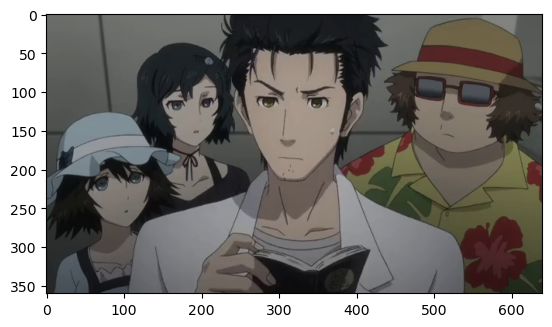

In [148]:
show(new_frame.astype('uint8'))